In [108]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

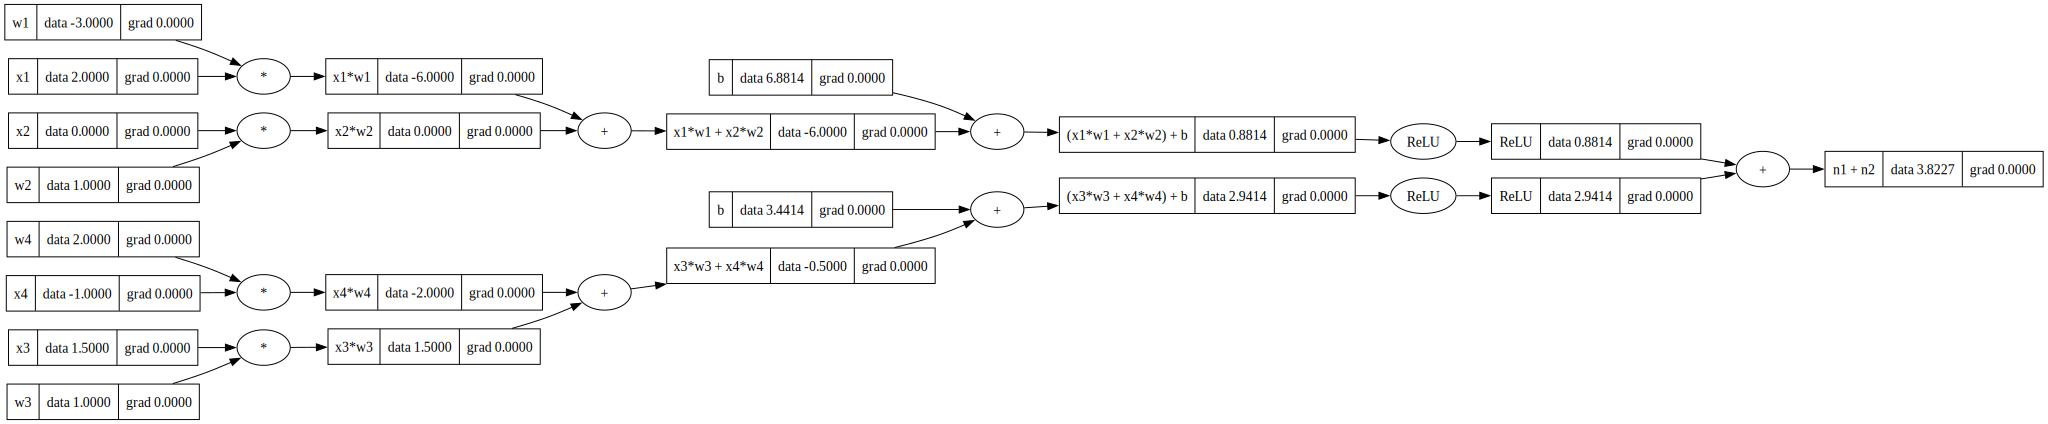

In [117]:
class Value:
    def __init__(self, data, label=" ", children=(), operation ="") -> None:
        self.data = float(data)
        self.label = label
        self.operation = operation
        self.backward = lambda: None
        self._prev = set(children)
        self.grad = 0
    
    def __add__(self, other):
        x  = Value(data=self.data + other.data, operation="+", children=(self, other))
        def backward():
            self.grad = 1.0 * x.grad
            other.grad = 1.0 * x.grad
        x.backward = backward
        return x

    def __mul__(self, other):
        x = Value(data=self.data * other.data, operation="*", children=(self, other))
        def backward():
            self.grad = other.data  * x.grad
            other.grad = self.data * x.grad
        x.backward = backward
        return x
    
    def relu(self):
        x = Value(data=0 if self.data < 0 else self.data, operation="ReLU", children=(self,))
        def backward():
            self.grad =  (x.data > 0) * x.grad
        x.backward = backward
        return x
    
# inputs x1,x2,x3,x4
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
x3 = Value(1.5, label='x3')
x4 = Value(-1.0, label='x4')
# weights w1,w2,w3,w4
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
w3 = Value(1.0, label='w3')
w4 = Value(2.0, label='w4')
# bias of the neuron
b1 = Value(6.8813735870195432, label='b')
b2 = Value(3.4413735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
x1w1x2w2b = x1w1x2w2 + b1; x1w1x2w2b.label='(x1*w1 + x2*w2) + b'
n1 = x1w1x2w2b.relu();n1.label="ReLU"

x3w3 = x3*w3; x3w3.label = 'x3*w3'
x4w4 = x4*w4; x4w4.label = 'x4*w4'
x3w3x4w4 = x3w3 + x4w4; x3w3x4w4.label='x3*w3 + x4*w4'
x3w3x4w4b = x3w3x4w4 + b2; x3w3x4w4b.label='(x3*w3 + x4*w4) + b'
n2 = x3w3x4w4b.relu();n2.label="ReLU"

n =n1+n2;n.label="n1 + n2"
draw_dot(n)


In [118]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(n)

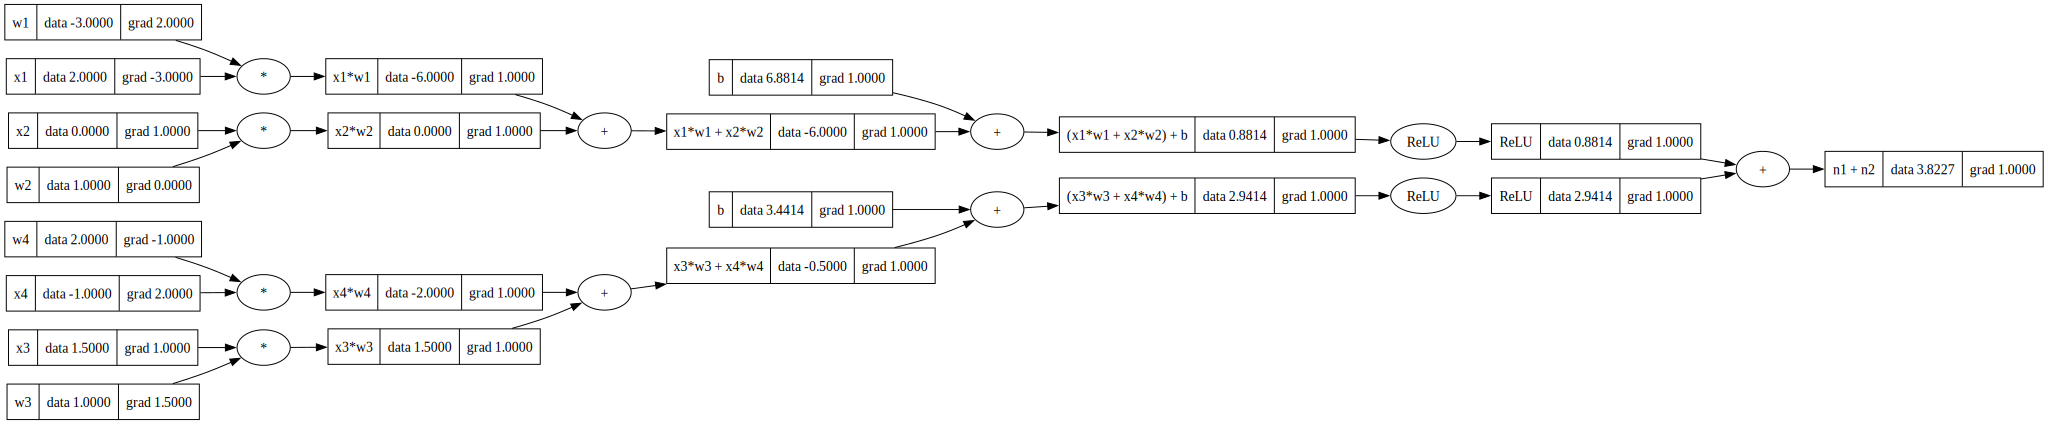

In [119]:
n.grad=1.0
for v in reversed(topo):
    v.backward()
draw_dot(n)